# Part 2: CAVs and scenicness

In [1]:
import os
import numpy as np
import pandas as pd
import torch
import matplotlib
import matplotlib.pyplot as plt
import random
import pickle
import collections
import nbimporter
import cv2
import torch.nn.functional as F
import math
import glob
import re


from matplotlib.colors import ListedColormap
from skimage import io, transform
from torch.utils.data import DataLoader, Dataset
from torchvision import utils, transforms, models
from torch.autograd import Variable
from PIL import Image
from sklearn import linear_model, metrics
from sklearn.model_selection import train_test_split
from statistics import mean, stdev
from scipy import stats, special
from tqdm.notebook import tqdm, tnrange

from p1_CreateTrainingDataframe import CreateTrainingDataframe
from p1_CreateTestDataframe import CreateTestDataframe
from p1_BrodenDataSet import BrodenDataset
from p1_RescaleImage import Rescale
from p1_TransformToTensor import ToTensor
from p1_GetVectorFromImage import GetVector
from p1_GetCosineSimilarityDistance import GetCosineSimilarityDistance
from p1_MakeVectorDictionary import MakeVectorDictionary
from p1_SubsetConceptImages import SubsetConceptImages

from p2_SoN_Dataset import SonDataset

Importing Jupyter notebook from p1_CreateTrainingDataframe.ipynb
Importing Jupyter notebook from p1_CreateTestDataframe.ipynb
Importing Jupyter notebook from p1_BrodenDataSet.ipynb
Importing Jupyter notebook from p1_RescaleImage.ipynb
Importing Jupyter notebook from p1_TransformToTensor.ipynb
Importing Jupyter notebook from p1_GetVectorFromImage.ipynb
Importing Jupyter notebook from p1_GetCosineSimilarityDistance.ipynb
Importing Jupyter notebook from p1_MakeVectorDictionary.ipynb
Importing Jupyter notebook from p1_SubsetConceptImages.ipynb
Importing Jupyter notebook from p2_SoN_Dataset.ipynb


Import necessary elements from part 1

In [2]:
basenet = models.resnet50(pretrained=True, progress=True)
out_layer = basenet._modules.get('avgpool')

In [3]:
## my own laptop:
# broden_dataset_path = '../data/broden1_384/'

## on guanabana:
broden_dataset_path = '/raid/data/datasets/broden1_384'

index_file_path = os.path.join(broden_dataset_path, 'index.csv')
label_file_path = os.path.join(broden_dataset_path, 'label.csv')

## Preprocess the Scenic-Or-Not images

In [4]:
son_path = '/raid/data/datasets/SoN/'
csv_path = '../data/votes.tsv'
image_path = son_path + 'images'

Read the csv file and only use the columns with 'ID' and 'Average score'. The image names are equal to the ID + .jpg

In [5]:
data_info = pd.read_csv(csv_path, delimiter ='\t', encoding='utf-8')

Certain images are to be deleted from the dataset as they are not correctly downloaded. These images are stored in the 'no exist' folder. These images are listed and their IDs are extracted. The image IDs are then linked to the dataframe indices, which are then removed. The index is reset afterwards and the dataframe is stored as .csv

In [6]:
if os.path.exists('../data/updated_votes.csv'):
    updated_votes = pd.read_csv('../data/updated_votes.csv', index_col = 0)
    
else:
    deleted_imgs = [f for f in glob.glob('/raid/data/datasets/SoN/images/no_exist/' + "*.jpg", recursive=False)]
    deleted_imgs = list(map(lambda x: [int(s) for s in re.findall(r'\d+', x)][0], deleted_imgs))

    remove_indices = tuple(map(lambda x: data_info.loc[data_info.ID == x].index[0], deleted_imgs))

    updated_votes = data_info.drop(data_info.index[[remove_indices]])
    updated_votes.reset_index(drop=True, inplace=True)
    
    updated_votes.to_csv('../data/updated_votes.csv')

Create a Dataset for the Scenic-Or-Not images

In [7]:
son_dataset = SonDataset('../data/updated_votes.csv', 
                         image_path, 
                         transform = transforms.Compose([transforms.Resize(224),
                                                         transforms.ToTensor(),
                                                         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                              std=[0.229, 0.224, 0.225])
                                                        ]))

Run all the SoN images through the model and store the activations in a dictionary. In which the image index in de *updated_votes_df* are the keys and the activation tensors the values.

In [8]:
if os.path.exists('../data/son_tensors.pickle'):
    with open('../data/son_tensors.pickle', 'rb') as handle:
        son_tensors = pickle.load(handle)
        
else:
    son_idxs = list(range(len(updated_votes)))
    son_tensors = MakeVectorDictionary(basenet,
                                      out_layer,
                                      son_dataset,
                                      son_idxs,
                                      file_name = 'son_tensors.pickle')

2 images are not able to get through the model and thus need to be removed from the *updated_votes_df*. The indices of the images are:
 - 52642
 - 201047

In [9]:
updated_votes.drop([52642, 201047], inplace=True)

For each SoN image the probability score for each concept from the Broden dataset is calculated. The probability score is calculated as follows: <br>
$CAV_{Broden} * tensor_{image} + bias_{Broden}$

The result is stored in a dataframe and written to a .csv file

In [10]:
son_idxs = list(son_tensors.keys())

In [19]:
with open('../data/filtered_broden_cavs.pickle', 'rb') as handle:
        broden_cavs = pickle.load(handle)

In [20]:
broden_concepts = list(broden_cavs.keys())

In [21]:
concept_score_matrix = np.zeros((len(son_tensors), len(broden_concepts)))

In [22]:
if os.path.exists('../data/concept_scores.csv'):
    concept_score_df = pd.read_csv('../data/concept_scores.csv', index_col = 0)
else:
    for i in tqdm(range(len(son_tensors))):
        son_img_activation = son_tensors[son_idxs[i]].numpy()
    
        for c in range(len(broden_concepts)):
            cav = broden_cavs[broden_concepts[c]]['cav']
            bias = broden_cavs[broden_concepts[c]]['bias']

            concept_score = np.dot(cav, son_img_activation) + bias
            concept_score_matrix[i][c] = concept_score
            
    concept_score_df = pd.DataFrame(concept_score_matrix, columns = broden_concepts)
    concept_score_df.to_csv('../data/concept_scores.csv')
        

A Kendall's Tau test is applied to check if which concepts correlate with an increase in scenicness. "Kendall’s tau is a measure of the correspondence between two rankings"

In [23]:
scenic_score = np.asarray(updated_votes.Average)

In [24]:
all_concepts = list(concept_score_df.columns)
kendall_tau_score = {'tau': [],
                    'p_value': []}

for concept in tqdm(all_concepts):
    concept_score = np.asarray(concept_score_df.loc[:,concept])
    tau, p_value = stats.kendalltau(concept_score, scenic_score)
    kendall_tau_score['tau'].append(tau)
    kendall_tau_score['p_value'].append(p_value)

In [25]:
spearman_score = {'rho': [],
                 'p_value' : []}

for concept in tqdm(all_concepts):
    concept_score = np.asarray(concept_score_df.loc[:,concept])
    rho, p_value = stats.spearmanr(concept_score, scenic_score)
    spearman_score['rho'].append(rho)
    spearman_score['p_value'].append(p_value)

In [26]:
kendall_tau_df = pd.DataFrame.from_dict(kendall_tau_score)
spearman_df = pd.DataFrame.from_dict(spearman_score)

In [27]:
kendall_tau_df['concept'] = all_concepts
spearman_df['concept'] = all_concepts

In [28]:
kendall_tau_df.sort_values(by=['tau'], ascending=True, inplace = True)
spearman_df.sort_values(by=['rho'], ascending = True, inplace = True)

In [29]:
kendall_tau_df

,tau,p_value,concept
3,-0.388663,0.0,building
26,-0.373547,0.0,street-s
18,-0.366121,0.0,sidewalk
141,-0.360514,0.0,crosswalk
346,-0.345220,0.0,parking_lot-s
...,...,...,...
419,0.403432,0.0,ocean-s
347,0.406211,0.0,valley-s
389,0.412510,0.0,island
323,0.431492,0.0,cliff


## Mapping

In [105]:
img_file = []
img_name = '136'
for directory, _ , _ in os.walk('/raid/data/datasets/SoN/images'):
    img_file.extend(glob.glob(os.path.join(directory, img_name + '.jpg')))

img_path = img_file[0]

To plot the map 

In [27]:
max_lat = max(updated_votes.Lat)
min_lat = min(updated_votes.Lat)

max_lon = max(updated_votes.Lon)
min_lon = min(updated_votes.Lon)

In [107]:
updated_votes['y_pos'] = updated_votes.loc[:,'Lat'].apply(lambda x: round((max_lat - x) * 10))
updated_votes['x_pos'] = updated_votes.loc[:,'Lon'].apply(lambda x: round((x + abs(min_lon)) * 10))

son_df = pd.merge(updated_votes, concept_score_df, left_index=True, right_index=True)

In [152]:
def custom_div_cmap(numcolors=11, name='custom_div_cmap',
                    mincol='gray', midcol='white', maxcol='orange'):
    
    """ Create a custom diverging colormap with three colors
    
    Default is blue to white to red with 11 colors.  Colors can be specified
    in any way understandable by matplotlib.colors.ColorConverter.to_rgb()
    """

    from matplotlib.colors import LinearSegmentedColormap 
    
    cmap = LinearSegmentedColormap.from_list(name=name, 
                                             colors =[mincol, midcol, maxcol],
                                             N=numcolors)
    return cmap

In [187]:
newcmp = custom_div_cmap(11, 'custom_cmap', '0.15', 'gold', 'lightgoldenrodyellow')

In [237]:
def plot_concept_score(concept, son_df,newcmp):
    
    # Intialize a matrix based on the maximum difference in longitude and latitude
    grid = np.zeros((110, 110))
    grid[:] = np.nan
    
    grid_count = np.zeros((110,110))
    
    if concept not in son_df.columns:
        raise ValueError ('concept not present in dataset')
    
    #Loop through every image
    for i in tqdm(range(len(son_df))):
        try:
            x = son_df.loc[i, 'x_pos']
            y = son_df.loc[i, 'y_pos']
            if np.isnan(grid[y][x]):
                grid[y][x] = np.array([son_df.loc[i, concept]])
                grid_count[y][x] += 1
            else:
                grid[y][x] += son_df.loc[i, concept]
                grid_count[y][x] += 1

        except:
            continue
    grid = special.expit((grid*100)/grid_count)
    #grid = grid/grid_count
    img_name = '../data/' + concept + '_concept_score.png'
    # Plot the matrix as an image
    %matplotlib inline
    current_cmap = matplotlib.cm.get_cmap(newcmp)
    current_cmap.set_bad(color='black')
    plt.imshow(grid, cmap = current_cmap, interpolation='bilinear', vmin=0, vmax=1)
    cbar = plt.colorbar()
    cbar.set_label('concept score')
    plt.title(concept)
    plt.axis('off')
    plt.savefig(img_name, bbox_inches='tight')
    plt.show()

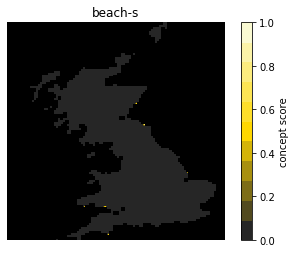

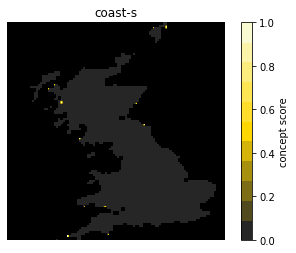

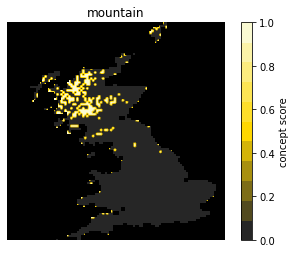

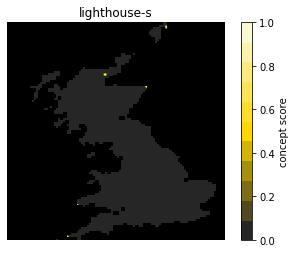

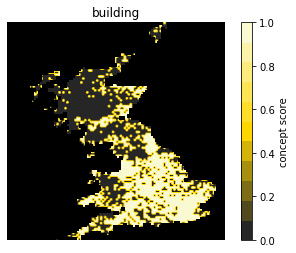

In [238]:
cl = ['beach-s', 'coast-s', 'mountain', 'lighthouse-s', 'building']
for c in cl:
    plot_concept_score(c, son_df, newcmp)